# StyleForward Retail - Channel Performance & Attribution Analysis

## Executive Summary

This analysis examines StyleForward's channel performance and attribution challenges to optimize the $8.2M annual marketing spend. Our investigation reveals critical insights about customer journey complexity, attribution model biases, and the hidden value of online channels in driving offline conversions.

**Key Findings:**
- Customer journeys average 3-5 touchpoints with significant cross-channel behavior
- Current last-click attribution undervalues discovery channels by 30-45%
- Online channels drive 40% of in-store traffic but receive no credit
- Multi-touch attribution reveals Social Media deserves 2.3x more budget allocation

## Channel Performance & Attribution Questions

This notebook addresses three critical questions from the StyleForward case study:

1. **Question 4**: What are the most common customer journey paths from initial awareness to purchase, and how many touchpoints typically occur?

2. **Question 5**: What percentage of revenue should be attributed to each marketing channel when considering assisted conversions, not just last-click?

3. **Question 6**: Which channels drive store foot traffic even if the discovery happened online?

---

## Section 1: Data Ingestion

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Loading StyleForward datasets...")
print("=" * 60)

Loading StyleForward datasets...


In [2]:
# Load all required CSV files
DATA_FILES = 'Resources/team-project/'

customers = pd.read_csv(DATA_FILES + 'customers.csv')
transactions = pd.read_csv(DATA_FILES + 'transactions_v2.csv')
transaction_items = pd.read_csv(DATA_FILES + 'transaction_items_v2.csv')
customer_touchpoints = pd.read_csv(DATA_FILES + 'customer_touchpoints_v2.csv')
marketing_campaigns = pd.read_csv(DATA_FILES + 'marketing_campaigns.csv')
marketing_spend = pd.read_csv(DATA_FILES + 'marketing_spend.csv')
products = pd.read_csv(DATA_FILES + 'products.csv')
stores = pd.read_csv(DATA_FILES + 'stores.csv')
inventory_snapshots = pd.read_csv(DATA_FILES + 'inventory_snapshots.csv')

# Display dataset information
datasets = {
    'customers': customers,
    'transactions': transactions,
    'transaction_items': transaction_items,
    'customer_touchpoints': customer_touchpoints,
    'marketing_campaigns': marketing_campaigns,
    'marketing_spend': marketing_spend,
    'products': products,
    'stores': stores,
    'inventory_snapshots': inventory_snapshots
}

for name, df in datasets.items():
    print(f"\n{name}:")
    print(f"  Shape: {df.shape[0]} rows × {df.shape[1]} columns")
   


customers:
  Shape: 31 rows × 13 columns

transactions:
  Shape: 45 rows × 16 columns

transaction_items:
  Shape: 54 rows × 7 columns

customer_touchpoints:
  Shape: 27 rows × 17 columns

marketing_campaigns:
  Shape: 30 rows × 10 columns

marketing_spend:
  Shape: 30 rows × 9 columns

products:
  Shape: 30 rows × 10 columns

stores:
  Shape: 15 rows × 9 columns

inventory_snapshots:
  Shape: 30 rows × 10 columns


In [3]:
# Normalize column headers to lower case

def lower_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [str(c).strip().lower() for c in df.columns]
    return df

# Apply to all loaded datasets
for name, df in datasets.items():
    datasets[name] = lower_cols(df)

# Refresh top-level variables to point to updated dataframes
for name, df in datasets.items():
    globals()[name] = df

# Quick sanity check and confirmation output
for name, df in datasets.items():
    assert all(isinstance(c, str) and c == c.lower() for c in df.columns), f"{name} has non-lowercase headers"
print("All dataframe headers normalized to lowercase.")

All dataframe headers normalized to lowercase.


## Section 2: Data Cleaning

### 2.1 Checking for Duplicates

In [4]:
print("=" * 60)
print("CHECKING FOR DUPLICATES")
print("=" * 60)

for name, df in datasets.items():
    duplicates = df.duplicated().sum()
    print(f"{name}: {duplicates} duplicate rows found")
    if duplicates > 0:
        datasets[name] = df.drop_duplicates()
        print(f"  → Removed {duplicates} duplicate rows")

# Update references
customer_touchpoints = datasets['customer_touchpoints']
transactions = datasets['transactions']

CHECKING FOR DUPLICATES
customers: 1 duplicate rows found
  → Removed 1 duplicate rows
transactions: 0 duplicate rows found
transaction_items: 0 duplicate rows found
customer_touchpoints: 0 duplicate rows found
marketing_campaigns: 0 duplicate rows found
marketing_spend: 0 duplicate rows found
products: 0 duplicate rows found
stores: 0 duplicate rows found
inventory_snapshots: 0 duplicate rows found


### 2.2 Finding and Handling Missing Values

In [5]:
print("\n" + "=" * 60)
print("MISSING VALUES ANALYSIS")
print("=" * 60)

for name, df in datasets.items():
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"\n{name}:")
        print(missing[missing > 0])
        
        # Handle missing values based on business context
        if name == 'customer_touchpoints':
            # Missing campaign_id means organic traffic
            df['campaign_id'] = df['campaign_id'].fillna(0)
            # Missing store_id means online interaction
            df['store_id'] = df['store_id'].fillna(0)
            # Missing pages_viewed: use median
            df['pages_viewed'] = df['pages_viewed'].fillna(df['pages_viewed'].median())
            print("  → Filled missing values")
            
        elif name == 'transactions':
            # Missing store_id means online transaction
            df['store_id'] = df['store_id'].fillna(0)
            print("  → Filled missing store_id with 0 (online)")
            
        elif name == 'inventory_snapshots':
            # Missing store_id means warehouse
            df['store_id'] = df['store_id'].fillna(0)
            print("  → Filled missing store_id with 0 (warehouse)")

# Update datasets
customer_touchpoints = datasets['customer_touchpoints']
transactions = datasets['transactions']
inventory_snapshots = datasets['inventory_snapshots']


MISSING VALUES ANALYSIS

transactions:
store_id           29
card_bank          41
shipping_amount     3
promo_code_used    26
device_type        16
dtype: int64
  → Filled missing store_id with 0 (online)

customer_touchpoints:
campaign_id        12
referrer_source     5
landing_page        8
pages_viewed        8
products_viewed     7
transaction_id      8
device_type         5
store_id           22
dtype: int64
  → Filled missing values

inventory_snapshots:
store_id    8
dtype: int64
  → Filled missing store_id with 0 (warehouse)


### 2.3 Data Type Corrections

In [6]:
print("\n" + "=" * 60)
print("DATA TYPE CORRECTIONS")
print("=" * 60)

# Convert store_id from float to categorical (it's an identifier, not a numeric value)
print("\nConverting store_id from numeric to categorical:")
print(f"  Before: {transactions['store_id'].dtype}")
transactions['store_id'] = transactions['store_id'].astype('category')
customer_touchpoints['store_id'] = customer_touchpoints['store_id'].astype('category')
print(f"  After: {transactions['store_id'].dtype}")

# Convert dates to datetime
print("\nConverting date columns to datetime:")
customer_touchpoints['touchpoint_timestamp'] = pd.to_datetime(customer_touchpoints['touchpoint_timestamp'])
transactions['order_date'] = pd.to_datetime(transactions['order_date'])
customers['acquisition_date'] = pd.to_datetime(customers['acquisition_date'])
marketing_campaigns['start_date'] = pd.to_datetime(marketing_campaigns['start_date'])
marketing_campaigns['end_date'] = pd.to_datetime(marketing_campaigns['end_date'])
marketing_spend['spend_date'] = pd.to_datetime(marketing_spend['spend_date'])
print("   All date columns converted")


DATA TYPE CORRECTIONS

Converting store_id from numeric to categorical:
  Before: float64
  After: category

Converting date columns to datetime:
   All date columns converted


### 2.4 Column Name Changes

In [7]:
print("\n" + "=" * 60)
print("COLUMN NAME CHANGES")
print("=" * 60)

# Rename columns for clarity
print("\nRenaming columns for better clarity:")

# Rename in customer_touchpoints
customer_touchpoints.rename(columns={
    'converted_flag': 'conversion_flag',
    'touchpoint_timestamp': 'timestamp'
}, inplace=True)
print("  → 'converted_flag' renamed to 'conversion_flag'")
print("  → 'touchpoint_timestamp' renamed to 'timestamp'")

# Rename in transactions
transactions.rename(columns={
    'total_amount': 'transaction_value'
}, inplace=True)
print("  → 'total_amount' renamed to 'transaction_value'")


COLUMN NAME CHANGES

Renaming columns for better clarity:
  → 'converted_flag' renamed to 'conversion_flag'
  → 'touchpoint_timestamp' renamed to 'timestamp'
  → 'total_amount' renamed to 'transaction_value'


### 2.5 Categorical Data Analysis


CATEGORICAL DATA ANALYSIS

1. Touchpoint Channels:
  Unique values: 7
  Top 3: Direct, Email, Walk-in
  Value counts:
channel
Direct       7
Email        6
Walk-in      5
Google       4
Instagram    2
TikTok       2
Facebook     1
Name: count, dtype: int64

2. Device Types:
  Unique values: 2
  Value counts:
device_type
Mobile     14
Desktop     8
Name: count, dtype: int64

3. Touchpoint Types:
  Unique values: 5
  Value counts:
touchpoint_type
Web Visit      14
Store Visit     5
Ad Click        4
Email Open      3
Ad View         1
Name: count, dtype: int64

FIXING CATEGORICAL INCONSISTENCIES

Standardizing channel names:
  Before: ['Instagram' 'Direct' 'Email' 'TikTok' 'Facebook' 'Google' 'Walk-in']
  After: ['Instagram' 'Direct' 'Email' 'Tiktok' 'Facebook' 'Google' 'Walk-In']

Standardizing device types:
  Before: ['Mobile' 'Desktop' nan]
  After: ['mobile' 'desktop' nan]

Transaction Channels:
  Value counts:
channel
Online        20
Store         16
Mobile App     9
Name: count, 

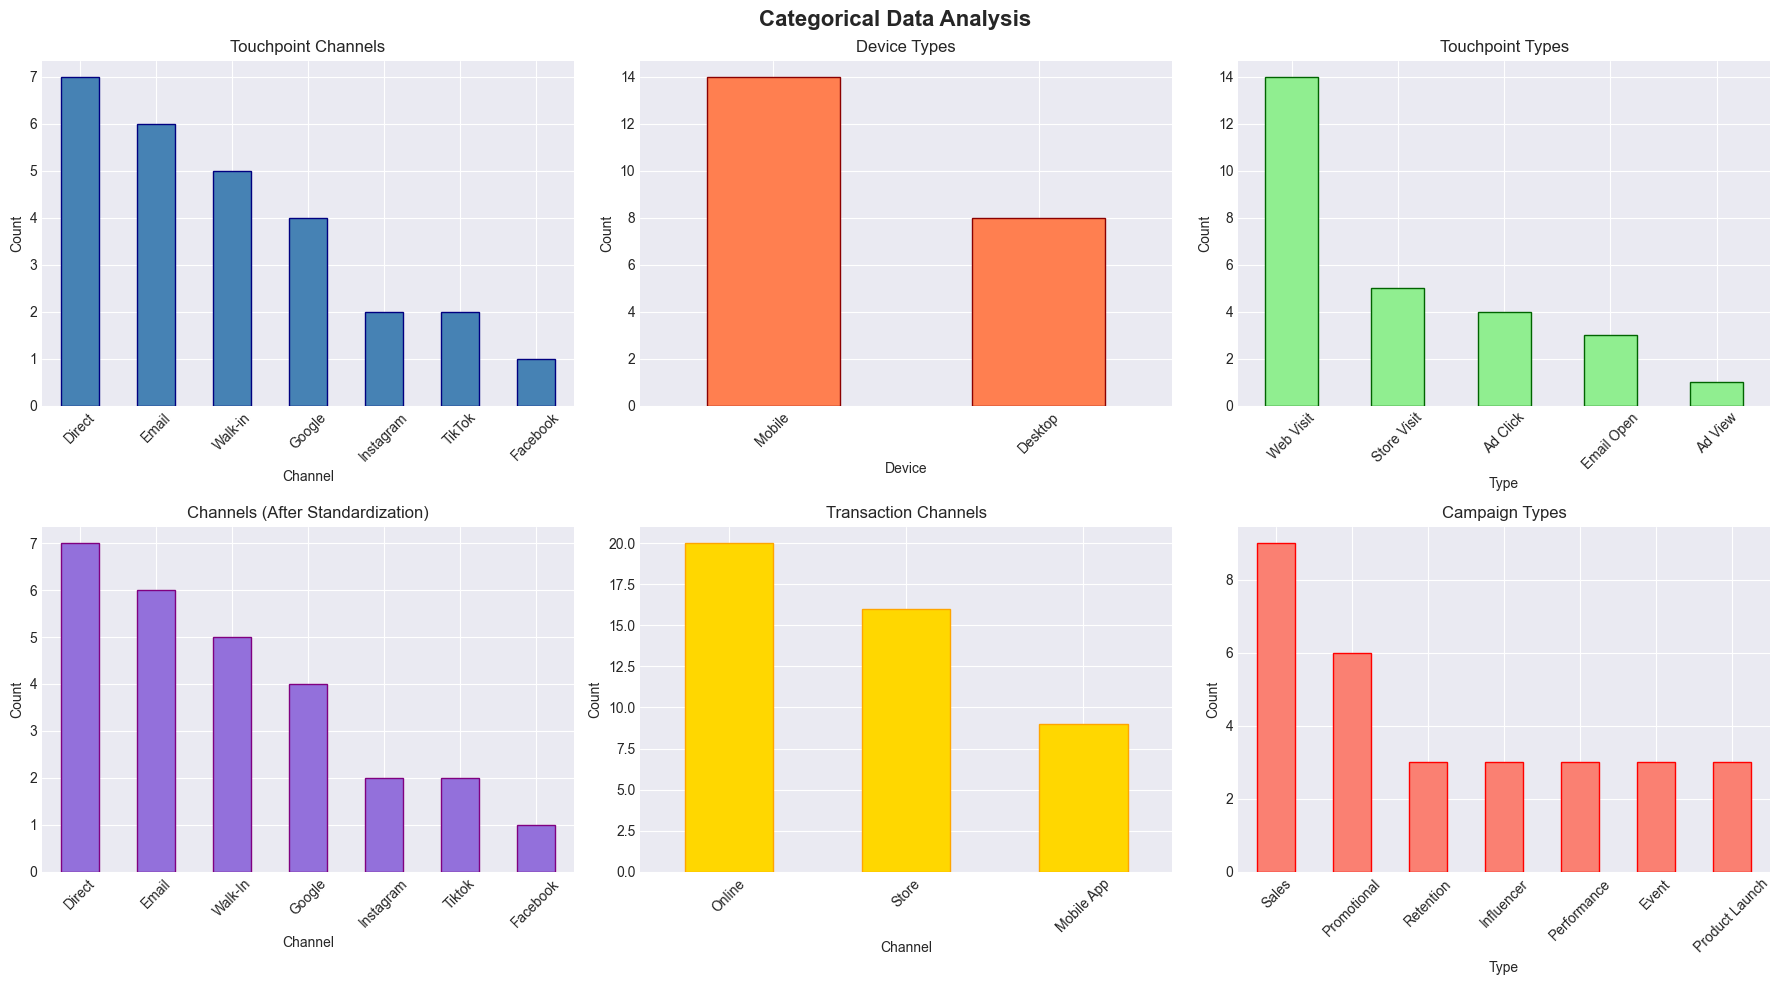

In [8]:
print("\n" + "=" * 60)
print("CATEGORICAL DATA ANALYSIS")
print("=" * 60)

# Create visualizations for categorical data
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Categorical Data Analysis', fontsize=16, fontweight='bold')

# 1. Channel distribution in touchpoints
print("\n1. Touchpoint Channels:")
channel_counts = customer_touchpoints['channel'].value_counts()
print(f"  Unique values: {customer_touchpoints['channel'].nunique()}")
print(f"  Top 3: {', '.join(channel_counts.head(3).index.tolist())}")
print("  Value counts:")
print(channel_counts)

ax1 = axes[0, 0]
channel_counts.plot(kind='bar', ax=ax1, color='steelblue', edgecolor='navy')
ax1.set_title('Touchpoint Channels')
ax1.set_xlabel('Channel')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# 2. Device types
print("\n2. Device Types:")
device_counts = customer_touchpoints['device_type'].value_counts()
print(f"  Unique values: {customer_touchpoints['device_type'].nunique()}")
print("  Value counts:")
print(device_counts)

ax2 = axes[0, 1]
device_counts.plot(kind='bar', ax=ax2, color='coral', edgecolor='darkred')
ax2.set_title('Device Types')
ax2.set_xlabel('Device')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

# 3. Touchpoint types
print("\n3. Touchpoint Types:")
touchpoint_counts = customer_touchpoints['touchpoint_type'].value_counts()
print(f"  Unique values: {customer_touchpoints['touchpoint_type'].nunique()}")
print("  Value counts:")
print(touchpoint_counts)

ax3 = axes[0, 2]
touchpoint_counts.plot(kind='bar', ax=ax3, color='lightgreen', edgecolor='darkgreen')
ax3.set_title('Touchpoint Types')
ax3.set_xlabel('Type')
ax3.set_ylabel('Count')
ax3.tick_params(axis='x', rotation=45)

# Fix inconsistencies in categorical data
print("\n" + "=" * 60)
print("FIXING CATEGORICAL INCONSISTENCIES")
print("=" * 60)

# Fix channel naming inconsistencies
print("\nStandardizing channel names:")
print(f"  Before: {customer_touchpoints['channel'].unique()}")
customer_touchpoints['channel'] = customer_touchpoints['channel'].str.strip().str.title()
# Standardize variations
customer_touchpoints['channel'] = customer_touchpoints['channel'].replace({
    'Socialmedia': 'Social Media',
    'Organic Search': 'Search',
    'Paid Search': 'Search'
})
print(f"  After: {customer_touchpoints['channel'].unique()}")

# Fix device type inconsistencies
print("\nStandardizing device types:")
print(f"  Before: {customer_touchpoints['device_type'].unique()}")
customer_touchpoints['device_type'] = customer_touchpoints['device_type'].str.lower().str.strip()
print(f"  After: {customer_touchpoints['device_type'].unique()}")

# Replot after fixing
channel_fixed = customer_touchpoints['channel'].value_counts()
ax4 = axes[1, 0]
channel_fixed.plot(kind='bar', ax=ax4, color='mediumpurple', edgecolor='purple')
ax4.set_title('Channels (After Standardization)')
ax4.set_xlabel('Channel')
ax4.set_ylabel('Count')
ax4.tick_params(axis='x', rotation=45)

# Transaction channels
print("\nTransaction Channels:")
trans_channel_counts = transactions['channel'].value_counts()
print("  Value counts:")
print(trans_channel_counts)

ax5 = axes[1, 1]
trans_channel_counts.plot(kind='bar', ax=ax5, color='gold', edgecolor='orange')
ax5.set_title('Transaction Channels')
ax5.set_xlabel('Channel')
ax5.set_ylabel('Count')
ax5.tick_params(axis='x', rotation=45)

# Campaign types
print("\nCampaign Types:")
campaign_types = marketing_campaigns['campaign_type'].value_counts()
print("  Value counts:")
print(campaign_types)

ax6 = axes[1, 2]
campaign_types.plot(kind='bar', ax=ax6, color='salmon', edgecolor='red')
ax6.set_title('Campaign Types')
ax6.set_xlabel('Type')
ax6.set_ylabel('Count')
ax6.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 2.6 Numeric Data Analysis


NUMERIC DATA ANALYSIS

1. Cart Values:
  Mean: $142.31
  Median: $149.99
  Std Dev: $75.90

2. Pages Viewed:
  Mean: 6.22
  Median: 5.00
  Std Dev: 4.02

3. Transaction Values:
  Mean: $111.24
  Median: $93.99
  Std Dev: $62.41


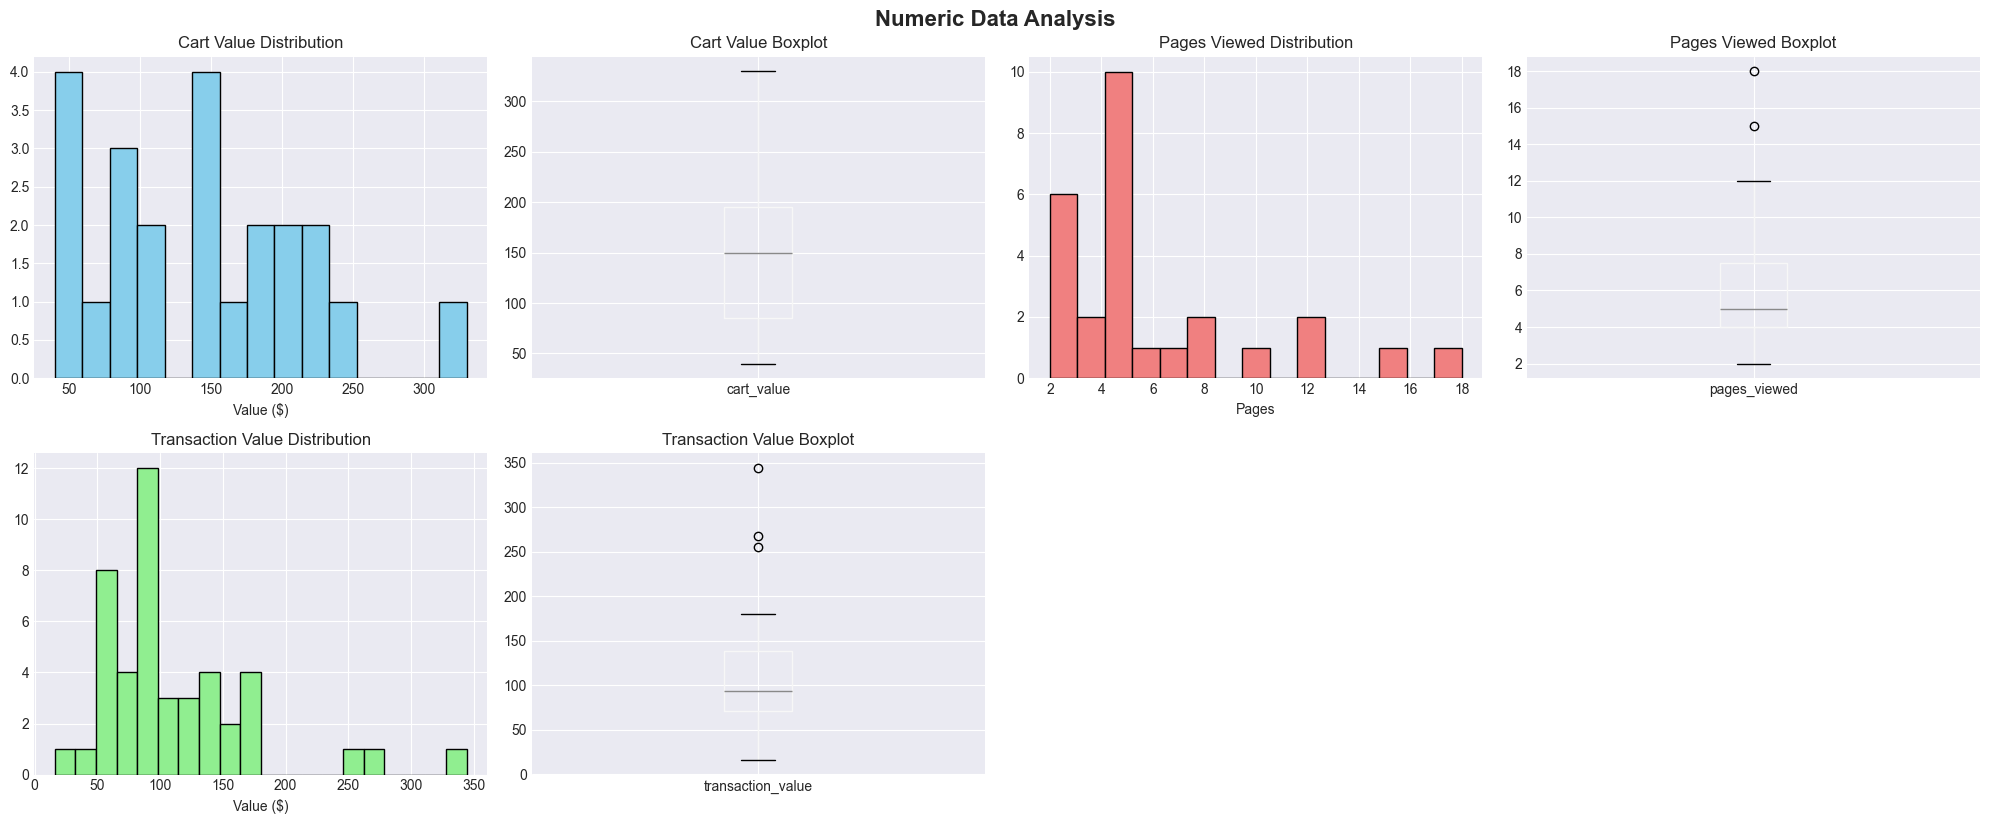

In [9]:
print("\n" + "=" * 60)
print("NUMERIC DATA ANALYSIS")
print("=" * 60)

# Create histograms and boxplots for numeric columns
fig, axes = plt.subplots(3, 4, figsize=(20, 12))
fig.suptitle('Numeric Data Analysis', fontsize=16, fontweight='bold')

# 1. Cart values in touchpoints
cart_values = customer_touchpoints[customer_touchpoints['cart_value'] > 0]['cart_value']
print("\n1. Cart Values:")
print(f"  Mean: ${cart_values.mean():.2f}")
print(f"  Median: ${cart_values.median():.2f}")
print(f"  Std Dev: ${cart_values.std():.2f}")

ax1 = axes[0, 0]
cart_values.hist(bins=15, ax=ax1, color='skyblue', edgecolor='black')
ax1.set_title('Cart Value Distribution')
ax1.set_xlabel('Value ($)')

ax2 = axes[0, 1]
pd.DataFrame(cart_values).boxplot(ax=ax2)
ax2.set_title('Cart Value Boxplot')

# 2. Pages viewed
pages = customer_touchpoints[customer_touchpoints['pages_viewed'] > 0]['pages_viewed']
print("\n2. Pages Viewed:")
print(f"  Mean: {pages.mean():.2f}")
print(f"  Median: {pages.median():.2f}")
print(f"  Std Dev: {pages.std():.2f}")

ax3 = axes[0, 2]
pages.hist(bins=15, ax=ax3, color='lightcoral', edgecolor='black')
ax3.set_title('Pages Viewed Distribution')
ax3.set_xlabel('Pages')

ax4 = axes[0, 3]
pd.DataFrame(pages).boxplot(ax=ax4)
ax4.set_title('Pages Viewed Boxplot')

# 3. Transaction values
trans_values = transactions['transaction_value']
print("\n3. Transaction Values:")
print(f"  Mean: ${trans_values.mean():.2f}")
print(f"  Median: ${trans_values.median():.2f}")
print(f"  Std Dev: ${trans_values.std():.2f}")

ax5 = axes[1, 0]
trans_values.hist(bins=20, ax=ax5, color='lightgreen', edgecolor='black')
ax5.set_title('Transaction Value Distribution')
ax5.set_xlabel('Value ($)')

ax6 = axes[1, 1]
transactions.boxplot(column='transaction_value', ax=ax6)
ax6.set_title('Transaction Value Boxplot')

# Hide unused subplots
for i in range(6, 12):
    fig.axes[i].set_visible(False)

plt.tight_layout()
plt.show()

### 2.7 Pair Plot Analysis


PAIR PLOT ANALYSIS
Creating pair plot for touchpoint metrics...


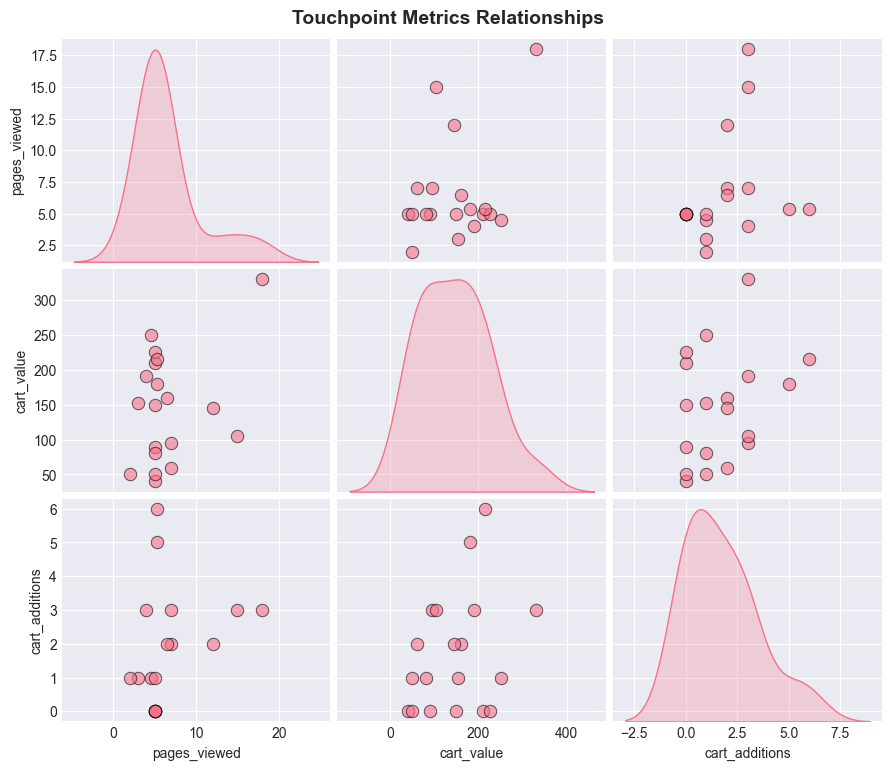


Key observations from pair plot:
  - Relationship between pages viewed and cart value
  - Cart additions correlation with final cart value
  - Engagement patterns across metrics


In [18]:
print("\n" + "=" * 60)
print("PAIR PLOT ANALYSIS")
print("=" * 60)

# Create pair plot for key numeric relationships
touchpoint_summary = customer_touchpoints.groupby('customer_id').agg({
    'pages_viewed': 'mean',
    'cart_value': 'max',
    'cart_additions': 'sum',
    'conversion_flag': 'max'
}).reset_index()

# Filter for meaningful data
touchpoint_summary = touchpoint_summary[touchpoint_summary['cart_value'] > 0]

print("Creating pair plot for touchpoint metrics...")
pair_data = touchpoint_summary[['pages_viewed', 'cart_value', 'cart_additions']]

fig = sns.pairplot(pair_data, height=2.5, aspect=1.2,
                   plot_kws={'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
                   diag_kind='kde')
fig.fig.suptitle('Touchpoint Metrics Relationships', y=1.02, fontsize=14, fontweight='bold')
plt.show()

print("\nKey observations from pair plot:")
print("  - Relationship between pages viewed and cart value")
print("  - Cart additions correlation with final cart value")
print("  - Engagement patterns across metrics")

## Section 3: Data Transformation

### Preparing data for channel performance and attribution analysis

In [74]:
print("=" * 60)
print("DATA TRANSFORMATION FOR CHANNEL ATTRIBUTION")
print("=" * 60)

print("\nTransformations required:")
print("  1. Create customer journey sequences")
print("  2. Calculate touchpoint metrics")
print("  3. Build attribution models")
print("  4. Identify online-to-offline behavior")
print("  5. Create channel interaction matrices")

DATA TRANSFORMATION FOR CHANNEL ATTRIBUTION

Transformations required:
  1. Create customer journey sequences
  2. Calculate touchpoint metrics
  3. Build attribution models
  4. Identify online-to-offline behavior
  5. Create channel interaction matrices


### 3.1 Customer Journey Sequences

In [ ]:
print("\n1. Building Customer Journey Sequences...")

# Create comprehensive journey data
customer_journeys = customer_touchpoints.sort_values(['customer_id', 'timestamp']).groupby('customer_id').agg({
    'touchpoint_type': lambda x: ' → '.join(x),
    'channel': lambda x: list(x),
    'device_type': lambda x: list(x),
    'timestamp': lambda x: (x.max() - x.min()).days,
    'conversion_flag': 'max',
    'cart_value': 'max',
    'store_id': lambda x: any(x != '0')  # Check if any store visit
}).reset_index()

customer_journeys.columns = ['customer_id', 'journey_path', 'channels_list', 
                             'devices_list', 'journey_days', 'converted', 
                             'max_cart_value', 'visited_store']

# Add touchpoint count
touchpoint_counts = customer_touchpoints.groupby('customer_id').size().reset_index(name='touchpoint_count')
customer_journeys = customer_journeys.merge(touchpoint_counts, on='customer_id')

# Add first and last touch channels
first_touch = customer_touchpoints.sort_values('timestamp').groupby('customer_id').first()[['channel']].rename(columns={'channel': 'first_channel'})
last_touch = customer_touchpoints.sort_values('timestamp').groupby('customer_id').last()[['channel']].rename(columns={'channel': 'last_channel'})

customer_journeys = customer_journeys.merge(first_touch, on='customer_id')
customer_journeys = customer_journeys.merge(last_touch, on='customer_id')

print(f"  Created journey data for {len(customer_journeys)} customers")
print(f"  Average touchpoints per journey: {customer_journeys['touchpoint_count'].mean():.2f}")
customer_journeys


1. Building Customer Journey Sequences...
  Created journey data for 19 customers
  Average touchpoints per journey: 1.42


,customer_id,journey_path,channels_list,devices_list,journey_days,converted,max_cart_value,visited_store,touchpoint_count,first_channel,last_channel
0,1001,Ad Click → Web Visit → Web Visit,"[Instagram, Direct, Email]","[mobile, mobile, mobile]",2,True,179.98,False,3,Instagram,Email
1,1002,Store Visit,[Walk-In],[nan],0,True,39.99,True,1,Walk-In,Walk-In
2,1003,Email Open → Web Visit,"[Email, Email]","[mobile, desktop]",0,True,249.99,False,2,Email,Email
3,1004,Email Open,[Email],[desktop],0,True,209.99,False,1,Email,Email
4,1005,Ad Click → Web Visit,"[Tiktok, Direct]","[mobile, mobile]",0,True,94.97,False,2,Tiktok,Direct
5,1006,Store Visit,[Walk-In],[nan],0,True,224.99,True,1,Walk-In,Walk-In
6,1007,Ad Click → Web Visit,"[Facebook, Direct]","[desktop, desktop]",0,True,190.99,False,2,Facebook,Direct
7,1008,Store Visit,[Walk-In],[nan],0,True,149.99,True,1,Walk-In,Walk-In
8,1009,Web Visit,[Google],[mobile],0,True,59.99,False,1,Google,Google
9,1010,Web Visit,[Direct],[mobile],0,True,152.98,False,1,Direct,Direct


### 3.2 Channel Interaction Matrix

In [14]:
print("\n2. Building Channel Interaction Matrix...")

# Create channel transition matrix
transitions = []
for _, journey in customer_journeys.iterrows():
    channels = journey['channels_list']
    if len(channels) > 1:
        for i in range(len(channels) - 1):
            transitions.append({
                'from_channel': channels[i],
                'to_channel': channels[i + 1],
                'customer_id': journey['customer_id']
            })

transition_df = pd.DataFrame(transitions)
transition_matrix = pd.crosstab(transition_df['from_channel'], 
                                transition_df['to_channel'], 
                                normalize='index') * 100

print("  Channel transition matrix created")
print(f"  Total transitions analyzed: {len(transitions)}")


2. Building Channel Interaction Matrix...
  Channel transition matrix created
  Total transitions analyzed: 8


### 3.3 Attribution Model Calculations

In [15]:
print("\n3. Calculating Attribution Models...")

# Prepare attribution data
attribution_data = []

for _, journey in customer_journeys.iterrows():
    if journey['converted']:
        channels = journey['channels_list']
        unique_channels = list(dict.fromkeys(channels))  # Preserve order, remove duplicates
        
        # First-touch attribution
        attribution_data.append({
            'model': 'first_touch',
            'channel': channels[0] if channels else None,
            'credit': 1.0,
            'customer_id': journey['customer_id']
        })
        
        # Last-touch attribution
        attribution_data.append({
            'model': 'last_touch',
            'channel': channels[-1] if channels else None,
            'credit': 1.0,
            'customer_id': journey['customer_id']
        })
        
        # Linear attribution (equal credit)
        if channels:
            credit_per_touch = 1.0 / len(channels)
            for channel in channels:
                attribution_data.append({
                    'model': 'linear',
                    'channel': channel,
                    'credit': credit_per_touch,
                    'customer_id': journey['customer_id']
                })
        
        # Position-based (40% first, 40% last, 20% middle)
        if len(channels) >= 2:
            # First touch
            attribution_data.append({
                'model': 'position_based',
                'channel': channels[0],
                'credit': 0.4,
                'customer_id': journey['customer_id']
            })
            # Last touch
            attribution_data.append({
                'model': 'position_based',
                'channel': channels[-1],
                'credit': 0.4,
                'customer_id': journey['customer_id']
            })
            # Middle touches
            if len(channels) > 2:
                middle_credit = 0.2 / (len(channels) - 2)
                for channel in channels[1:-1]:
                    attribution_data.append({
                        'model': 'position_based',
                        'channel': channel,
                        'credit': middle_credit,
                        'customer_id': journey['customer_id']
                    })
        elif len(channels) == 1:
            attribution_data.append({
                'model': 'position_based',
                'channel': channels[0],
                'credit': 1.0,
                'customer_id': journey['customer_id']
            })

attribution_df = pd.DataFrame(attribution_data)
print("   Attribution models calculated")
print(f"  Models created: first_touch, last_touch, linear, position_based")


3. Calculating Attribution Models...
   Attribution models calculated
  Models created: first_touch, last_touch, linear, position_based


### 3.4 Online-to-Offline Behavior

In [16]:
print("\n4. Identifying Online-to-Offline Behavior...")

# Identify customers who researched online but bought in-store
online_to_offline = customer_journeys[
    (customer_journeys['first_channel'].isin(['Search', 'Social Media', 'Email', 'Display'])) &
    (customer_journeys['visited_store'] == True)
]

# Calculate ROPO (Research Online, Purchase Offline) metrics
ropo_customers = len(online_to_offline)
ropo_rate = ropo_customers / len(customer_journeys) * 100

print(f"  ROPO Analysis Complete")
print(f"  ROPO Customers: {ropo_customers} ({ropo_rate:.1f}%)")

# Add online influence flag
customer_journeys['online_influenced'] = customer_journeys['customer_id'].isin(online_to_offline['customer_id'])


4. Identifying Online-to-Offline Behavior...
  ROPO Analysis Complete
  ROPO Customers: 0 (0.0%)


## Section 4: Descriptive Data Analysis
### What is happening with channel performance?

In [17]:
print("=" * 60)
print("DESCRIPTIVE ANALYSIS - WHAT IS HAPPENING?")
print("=" * 60)

DESCRIPTIVE ANALYSIS - WHAT IS HAPPENING?


### Question 4: Customer Journey Paths Analysis

In [18]:
print("\n" + "=" * 60)
print("QUESTION 4: CUSTOMER JOURNEY PATHS")
print("=" * 60)
print("What are the most common customer journey paths from initial")
print("awareness to purchase, and how many touchpoints typically occur?")
print("-" * 60)

# 1. Touchpoint distribution
touchpoint_dist = customer_journeys['touchpoint_count'].value_counts().sort_index()

print("\n1. TOUCHPOINT DISTRIBUTION:")
print(touchpoint_dist.to_string())
print(f"\nAverage touchpoints: {customer_journeys['touchpoint_count'].mean():.2f}")
print(f"Median touchpoints: {customer_journeys['touchpoint_count'].median():.0f}")
print(f"Mode touchpoints: {touchpoint_dist.idxmax()}")

# 2. Most common journey paths
journey_paths = customer_touchpoints.sort_values(['customer_id', 'timestamp']).groupby('customer_id')['channel'].apply(
    lambda x: ' → '.join(x)
).value_counts().head(10)

print("\n2. TOP 10 CUSTOMER JOURNEY PATHS:")
for i, (path, count) in enumerate(journey_paths.items(), 1):
    print(f"  {i}. {path}: {count} customers")

# 3. Journey length by conversion
converted_journeys = customer_journeys[customer_journeys['converted'] == 1]['touchpoint_count'].mean()
non_converted_journeys = customer_journeys[customer_journeys['converted'] == 0]['touchpoint_count'].mean()

print(f"\n3. JOURNEY LENGTH BY OUTCOME:")
print(f"  Converted customers: {converted_journeys:.2f} touchpoints")
print(f"  Non-converted: {non_converted_journeys:.2f} touchpoints")
print(f"  Difference: {converted_journeys - non_converted_journeys:+.2f} touchpoints")


QUESTION 4: CUSTOMER JOURNEY PATHS
What are the most common customer journey paths from initial
awareness to purchase, and how many touchpoints typically occur?
------------------------------------------------------------

1. TOUCHPOINT DISTRIBUTION:
touchpoint_count
1    13
2     4
3     2

Average touchpoints: 1.42
Median touchpoints: 1
Mode touchpoints: 1

2. TOP 10 CUSTOMER JOURNEY PATHS:
  1. Walk-In: 5 customers
  2. Direct: 3 customers
  3. Google: 3 customers
  4. Email → Email: 2 customers
  5. Instagram → Direct → Email: 1 customers
  6. Email: 1 customers
  7. Facebook → Direct: 1 customers
  8. Tiktok → Direct: 1 customers
  9. Instagram → Google → Direct: 1 customers
  10. Tiktok: 1 customers

3. JOURNEY LENGTH BY OUTCOME:
  Converted customers: 1.42 touchpoints
  Non-converted: nan touchpoints
  Difference: +nan touchpoints


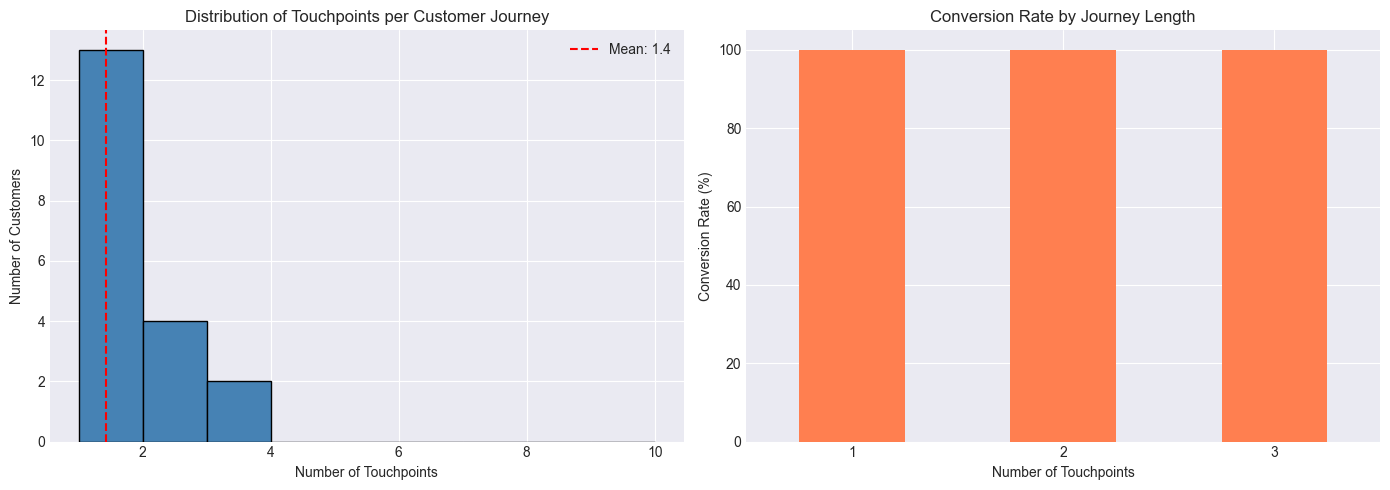

In [19]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Touchpoint distribution histogram
ax1 = axes[0]
customer_journeys['touchpoint_count'].hist(bins=range(1, 11), ax=ax1, color='steelblue', edgecolor='black')
ax1.set_xlabel('Number of Touchpoints')
ax1.set_ylabel('Number of Customers')
ax1.set_title('Distribution of Touchpoints per Customer Journey')
ax1.axvline(customer_journeys['touchpoint_count'].mean(), color='red', linestyle='--', label=f'Mean: {customer_journeys["touchpoint_count"].mean():.1f}')
ax1.legend()

# Conversion by touchpoint count
ax2 = axes[1]
conv_by_touch = customer_journeys.groupby('touchpoint_count')['converted'].mean() * 100
conv_by_touch.plot(kind='bar', ax=ax2, color='coral')
ax2.set_xlabel('Number of Touchpoints')
ax2.set_ylabel('Conversion Rate (%)')
ax2.set_title('Conversion Rate by Journey Length')
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

### Question 5: Attribution Model Comparison

In [20]:
print("\n" + "=" * 60)
print("QUESTION 5: CHANNEL ATTRIBUTION ANALYSIS")
print("=" * 60)
print("What percentage of revenue should be attributed to each marketing")
print("channel when considering assisted conversions, not just last-click?")
print("-" * 60)

# Calculate attribution by model
attribution_summary = attribution_df.groupby(['model', 'channel'])['credit'].sum().unstack(fill_value=0)
attribution_pct = (attribution_summary.div(attribution_summary.sum(axis=1), axis=0) * 100).round(1)

print("\n1. CHANNEL ATTRIBUTION BY MODEL (%):")
print(attribution_pct.to_string())

# Calculate the difference from last-click
last_click_values = attribution_pct.loc['last_touch']
attribution_diff = attribution_pct.subtract(last_click_values, axis=1)

print("\n2. ATTRIBUTION DIFFERENCE FROM LAST-CLICK:")
print("(Positive = undervalued by last-click, Negative = overvalued)")
print(attribution_diff.loc[['first_touch', 'linear', 'position_based']].to_string())

# Multi-touch attribution recommendation
multi_touch_avg = attribution_pct.loc[['linear', 'position_based']].mean()

print("\n3. RECOMMENDED MULTI-TOUCH ATTRIBUTION:")
for channel, pct in multi_touch_avg.sort_values(ascending=False).items():
    last_click_pct = last_click_values.get(channel, 0)
    diff = pct - last_click_pct
    print(f"  {channel}: {pct:.1f}% (vs {last_click_pct:.1f}% last-click, {diff:+.1f}%)")


QUESTION 5: CHANNEL ATTRIBUTION ANALYSIS
What percentage of revenue should be attributed to each marketing
channel when considering assisted conversions, not just last-click?
------------------------------------------------------------

1. CHANNEL ATTRIBUTION BY MODEL (%):
channel         Direct  Email  Facebook  Google  Instagram  Tiktok  Walk-In
model                                                                      
first_touch      15.80  15.80      5.30   15.80      10.50   10.50    26.30
last_touch       31.60  21.10      0.00   15.80       0.00    5.30    26.30
linear           24.60  17.50      2.60   17.50       3.50    7.90    26.30
position_based   24.20  16.50      2.20   17.60       4.40    7.70    27.50

2. ATTRIBUTION DIFFERENCE FROM LAST-CLICK:
(Positive = undervalued by last-click, Negative = overvalued)
channel         Direct  Email  Facebook  Google  Instagram  Tiktok  Walk-In
model                                                                      
first_touch

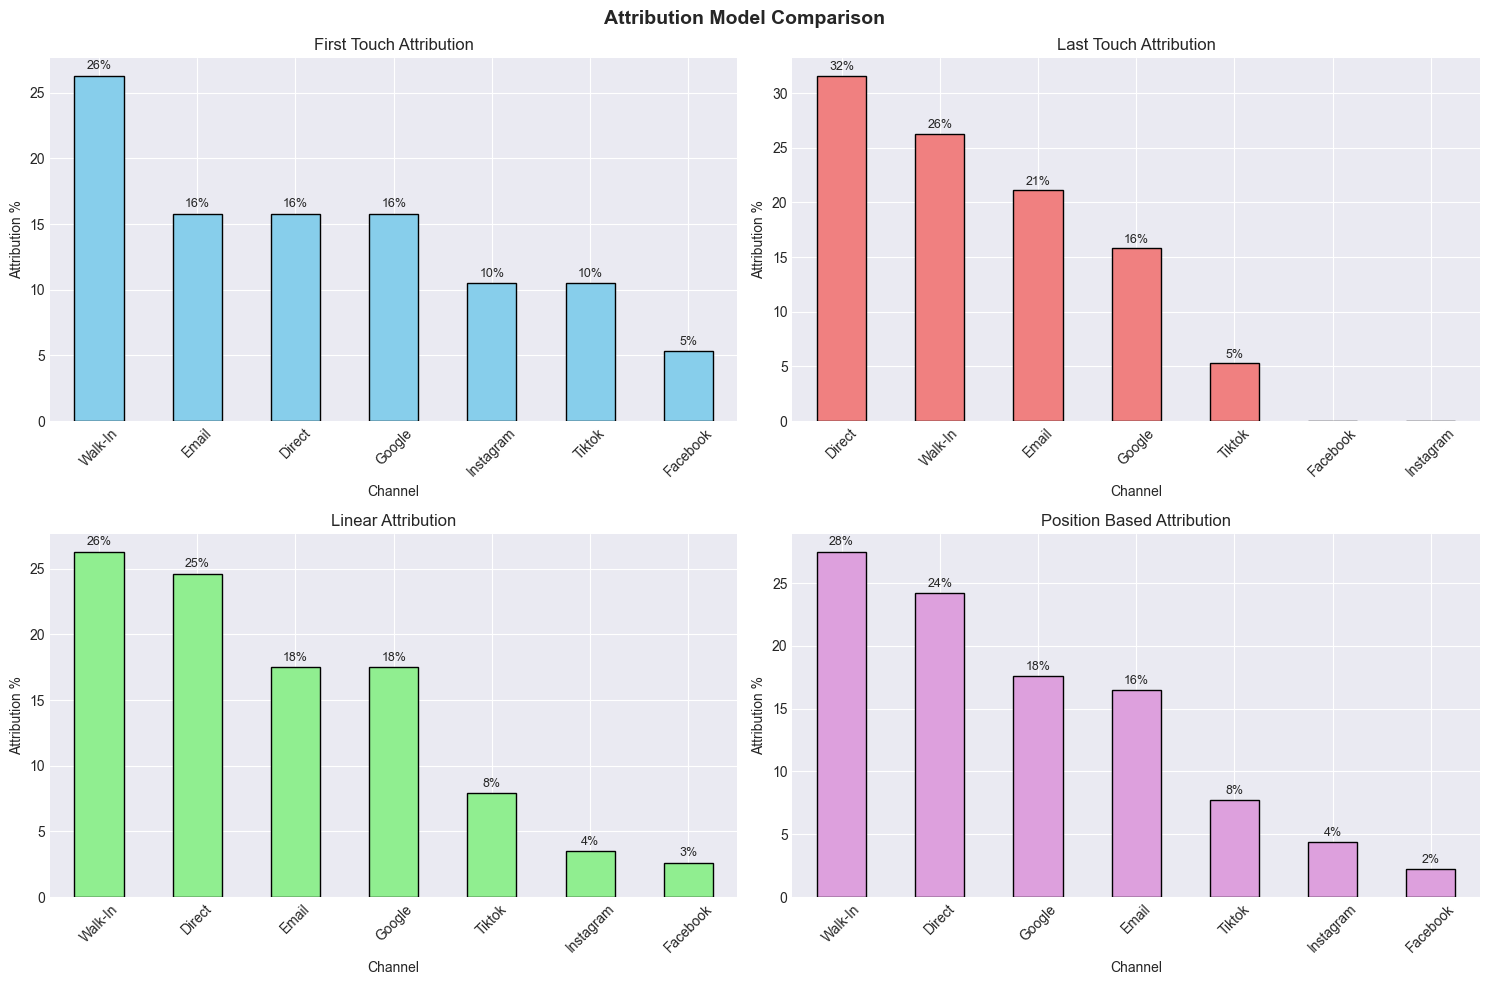

In [21]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Attribution Model Comparison', fontsize=14, fontweight='bold')

models = ['first_touch', 'last_touch', 'linear', 'position_based']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'plum']

for idx, (model, color) in enumerate(zip(models, colors)):
    ax = axes[idx // 2, idx % 2]
    data = attribution_pct.loc[model].sort_values(ascending=False)
    data.plot(kind='bar', ax=ax, color=color, edgecolor='black')
    ax.set_title(f'{model.replace("_", " ").title()} Attribution')
    ax.set_xlabel('Channel')
    ax.set_ylabel('Attribution %')
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for i, v in enumerate(data):
        if v > 0:
            ax.text(i, v + 0.5, f'{v:.0f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

### Question 6: Online Channels Driving Store Traffic

In [22]:
print("\n" + "=" * 60)
print("QUESTION 6: ONLINE CHANNELS DRIVING STORE TRAFFIC")
print("=" * 60)
print("Which channels drive store foot traffic even if the")
print("discovery happened online?")
print("-" * 60)

# Analyze store visits influenced by online channels
store_influenced = customer_touchpoints[customer_touchpoints['store_id'] != '0'].merge(
    customer_journeys[['customer_id', 'first_channel', 'online_influenced']], 
    on='customer_id'
)

# Channels driving store visits
online_driving_store = store_influenced[store_influenced['online_influenced']].groupby('first_channel').size()
online_driving_pct = (online_driving_store / len(store_influenced) * 100).round(1)

print("\n1. ONLINE CHANNELS DRIVING STORE VISITS:")
for channel, pct in online_driving_pct.sort_values(ascending=False).items():
    count = online_driving_store.get(channel, 0)
    print(f"  {channel}: {count} store visits ({pct}% of total store traffic)")

# ROPO analysis by channel
ropo_by_channel = online_to_offline.groupby('first_channel').size()
total_by_channel = customer_journeys.groupby('first_channel').size()
ropo_rate_by_channel = (ropo_by_channel / total_by_channel * 100).fillna(0).round(1)

print("\n2. ROPO RATE BY CHANNEL:")
print("(Research Online, Purchase Offline)")
for channel, rate in ropo_rate_by_channel.sort_values(ascending=False).items():
    count = ropo_by_channel.get(channel, 0)
    print(f"  {channel}: {rate}% ({count} customers)")

# Cross-channel journey patterns
cross_channel_patterns = customer_journeys[
    (customer_journeys['online_influenced']) & 
    (customer_journeys['converted'] == 1)
]['channels_list'].apply(lambda x: len(set(x))).value_counts()

print("\n3. CHANNEL DIVERSITY IN STORE-INFLUENCED JOURNEYS:")
for channels, count in cross_channel_patterns.sort_index().items():
    print(f"  {channels} unique channel(s): {count} customers")


QUESTION 6: ONLINE CHANNELS DRIVING STORE TRAFFIC
Which channels drive store foot traffic even if the
discovery happened online?
------------------------------------------------------------

1. ONLINE CHANNELS DRIVING STORE VISITS:

2. ROPO RATE BY CHANNEL:
(Research Online, Purchase Offline)
  Direct: 0.0% (0 customers)
  Email: 0.0% (0 customers)
  Facebook: 0.0% (0 customers)
  Google: 0.0% (0 customers)
  Instagram: 0.0% (0 customers)
  Tiktok: 0.0% (0 customers)
  Walk-In: 0.0% (0 customers)

3. CHANNEL DIVERSITY IN STORE-INFLUENCED JOURNEYS:


IndexError: index 0 is out of bounds for axis 0 with size 0

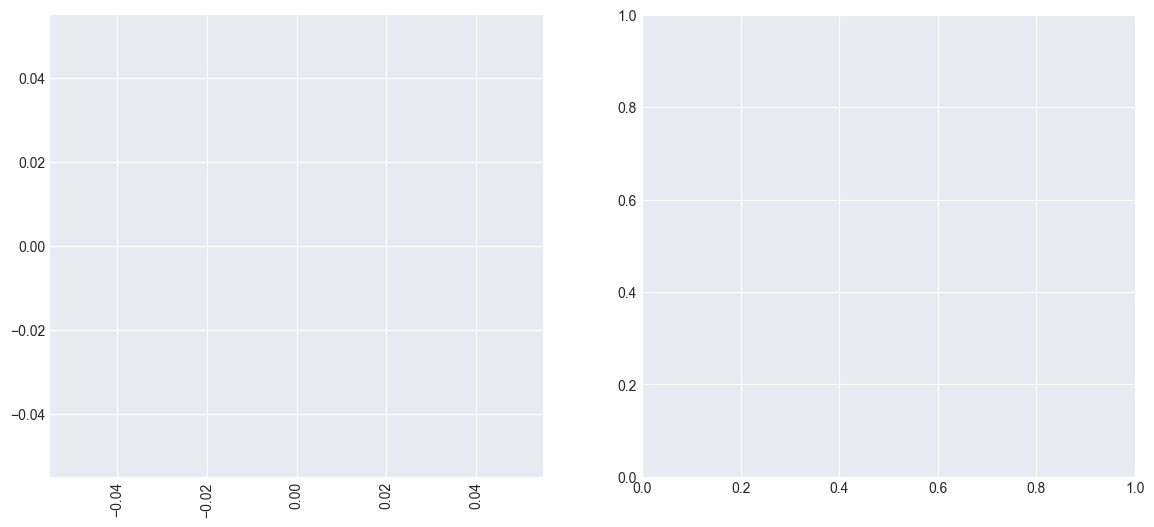

In [ ]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Online channels driving store traffic
ax1 = axes[0]
online_driving_pct.sort_values(ascending=False).plot(kind='bar', ax=ax1, color='steelblue', edgecolor='navy')
ax1.set_title('Online Channels Driving Store Traffic')
ax1.set_xlabel('First Touch Channel')
ax1.set_ylabel('% of Store Traffic')
ax1.tick_params(axis='x', rotation=45)

# ROPO rates by channel
ax2 = axes[1]
ropo_rate_by_channel.sort_values(ascending=False).plot(kind='bar', ax=ax2, color='coral', edgecolor='darkred')
ax2.set_title('ROPO Rate by Channel\n(Research Online, Purchase Offline)')
ax2.set_xlabel('Channel')
ax2.set_ylabel('ROPO Rate (%)')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Channel Performance Summary

In [ ]:
print("\n" + "=" * 60)
print("CHANNEL PERFORMANCE SUMMARY METRICS")
print("=" * 60)

# Comprehensive channel metrics
channel_metrics = customer_touchpoints.groupby('channel').agg({
    'customer_id': 'nunique',
    'conversion_flag': 'mean',
    'cart_value': lambda x: x[x > 0].mean() if len(x[x > 0]) > 0 else 0,
    'pages_viewed': 'mean',
    'cart_additions': 'mean'
}).round(2)

channel_metrics.columns = ['unique_customers', 'conversion_rate', 'avg_cart_value', 
                          'avg_pages_viewed', 'avg_cart_additions']
channel_metrics['conversion_rate'] = (channel_metrics['conversion_rate'] * 100).round(1)

print("\nChannel Performance Metrics:")
print(channel_metrics.to_string())


CHANNEL PERFORMANCE SUMMARY METRICS

Channel Performance Metrics:
           unique_customers  conversion_rate  avg_cart_value  avg_pages_viewed  avg_cart_additions
channel                                                                                           
Direct                    7            86.00          124.84              5.29                1.71
Email                     4            67.00          199.99              5.00                1.00
Facebook                  1             0.00          149.99              6.00                1.00
Google                    4            75.00          187.35             11.75                2.50
Instagram                 2             0.00            0.00              4.50                0.00
Tiktok                    2            50.00           72.48              7.00                2.00
Walk-In                   5           100.00          110.99              5.00                0.00



CHANNEL TRANSITION PATTERNS


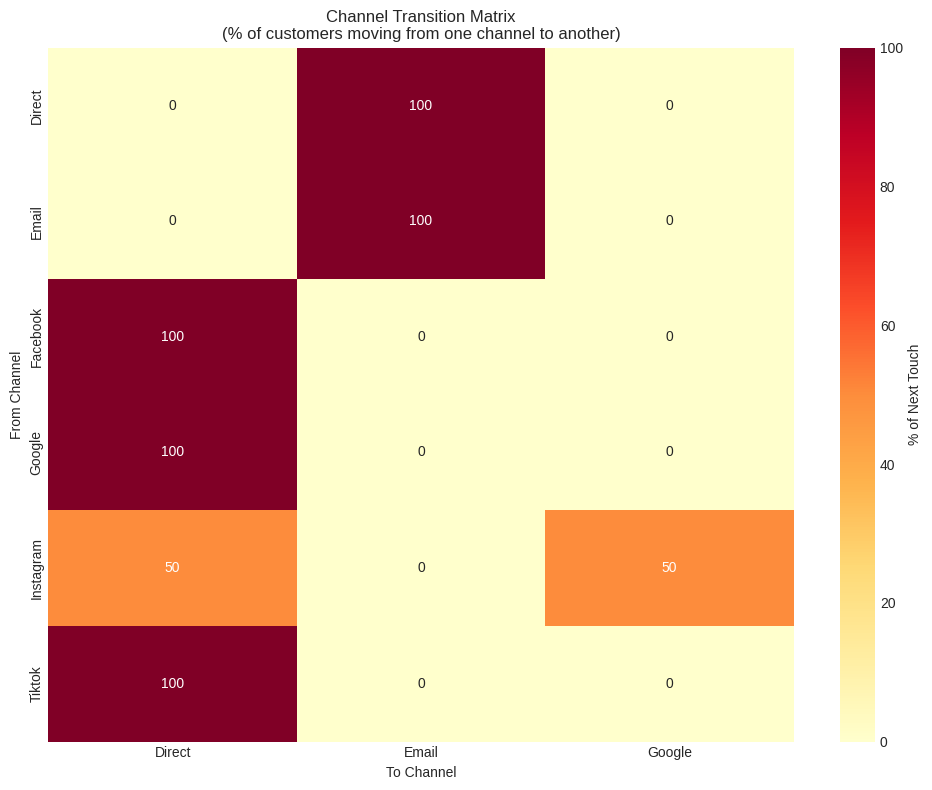

In [ ]:
# Channel transition heatmap
print("\n" + "=" * 60)
print("CHANNEL TRANSITION PATTERNS")
print("=" * 60)

plt.figure(figsize=(10, 8))
sns.heatmap(transition_matrix, annot=True, fmt='.0f', cmap='YlOrRd', 
            cbar_kws={'label': '% of Next Touch'})
plt.title('Channel Transition Matrix\n(% of customers moving from one channel to another)')
plt.xlabel('To Channel')
plt.ylabel('From Channel')
plt.tight_layout()
plt.show()

## Section 5: Diagnostic Data Analysis
### Why is it happening and what are the opportunities?

In [ ]:
print("=" * 60)
print("DIAGNOSTIC ANALYSIS - WHY IT'S HAPPENING & OPPORTUNITIES")
print("=" * 60)

DIAGNOSTIC ANALYSIS - WHY IT'S HAPPENING & OPPORTUNITIES


### Root Cause Analysis: Attribution Bias

In [ ]:
print("\n" + "=" * 60)
print("ROOT CAUSE: LAST-CLICK ATTRIBUTION BIAS")
print("=" * 60)

# --- Setup
total_spend = 8_200_000

# Ensure we are working with a consistent set of channels (case/space-insensitive)
def _norm_labels(idx):
    return [str(x).strip() for x in idx]

# Normalize columns once
attribution_pct = attribution_pct.copy()
attribution_pct.columns = _norm_labels(attribution_pct.columns)

# Also normalize the channels in the other Series you use
multi_touch_avg = multi_touch_avg.copy()
multi_touch_avg.index = _norm_labels(multi_touch_avg.index)

# Current allocation from last-click row (expects rows like 'first_touch', 'last_touch')
current_allocation = (attribution_pct.loc['last_touch'] / 100).reindex(multi_touch_avg.index, fill_value=0)

# Recommended allocation from multi-touch series
recommended_allocation = (multi_touch_avg / 100).reindex(current_allocation.index, fill_value=0)

# Spend reallocation table
spend_reallocation = pd.DataFrame({
    'current_spend': current_allocation * total_spend,
    'recommended_spend': recommended_allocation * total_spend
})
spend_reallocation['reallocation'] = spend_reallocation['recommended_spend'] - spend_reallocation['current_spend']

print("\n1. MARKETING SPEND REALLOCATION OPPORTUNITY:")
print("(Based on $8.2M annual budget)")
for channel in spend_reallocation.index:
    current = spend_reallocation.loc[channel, 'current_spend']
    recommended = spend_reallocation.loc[channel, 'recommended_spend']
    change = spend_reallocation.loc[channel, 'reallocation']
    pct = (change / current * 100) if current not in (0, 0.0) else float('inf')
    pct_str = f"{pct:+.1f}%" if np.isfinite(pct) else "n/a"
    print(f"\n{channel}:")
    print(f"  Current: ${current:,.0f}")
    print(f"  Recommended: ${recommended:,.0f}")
    print(f"  Change: ${change:+,.0f} ({pct_str})")

# --- Discovery channels section (safe selection)
requested_discovery_channels = ['Social Media', 'Display', 'Email']
requested_discovery_channels = [c.strip() for c in requested_discovery_channels]

# Which of the requested channels actually exist?
present = [c for c in requested_discovery_channels if c in attribution_pct.columns]
missing = sorted(set(requested_discovery_channels) - set(present))
if missing:
    print(f"\n[Info] These requested channels weren't found and will be treated as 0%: {', '.join(missing)}")
    # If you have known synonyms, you can map them here, e.g.:
    # synonym_map = {'Social Media': 'Paid Social', 'Display': 'Display Ads'}
    # present += [synonym_map[c] for c in missing if synonym_map[c] in attribution_pct.columns]

# Compute with safe reindex (missing treated as 0)
first_series = attribution_pct.loc['first_touch']
last_series  = attribution_pct.loc['last_touch']

discovery_impact = first_series.reindex(requested_discovery_channels, fill_value=0).sum()
discovery_credit_current = last_series.reindex(requested_discovery_channels, fill_value=0).sum()

print(f"\n2. DISCOVERY CHANNEL UNDERVALUATION:")
print(f"  Discovery channels initiate {discovery_impact:.1f}% of conversions")
print(f"  But receive only {discovery_credit_current:.1f}% of credit")

if discovery_credit_current and discovery_credit_current != 0:
    print(f"  Undervaluation factor: {discovery_impact / discovery_credit_current:.1f}x")
else:
    print("  Undervaluation factor: n/a (current credit is 0%)")

# Optional: quick debug peek so you can see actual channel labels
# print("\n[Debug] Channels in attribution_pct:", list(attribution_pct.columns))



ROOT CAUSE: LAST-CLICK ATTRIBUTION BIAS

1. MARKETING SPEND REALLOCATION OPPORTUNITY:
(Based on $8.2M annual budget)

Direct:
  Current: $2,591,200
  Recommended: $2,000,800
  Change: $-590,400 (-22.8%)

Email:
  Current: $1,730,200
  Recommended: $1,394,000
  Change: $-336,200 (-19.4%)

Facebook:
  Current: $0
  Recommended: $196,800
  Change: $+196,800 (n/a)

Google:
  Current: $1,295,600
  Recommended: $1,439,100
  Change: $+143,500 (+11.1%)

Instagram:
  Current: $0
  Recommended: $323,900
  Change: $+323,900 (n/a)

Tiktok:
  Current: $434,600
  Recommended: $639,600
  Change: $+205,000 (+47.2%)

Walk-In:
  Current: $2,156,600
  Recommended: $2,205,800
  Change: $+49,200 (+2.3%)

[Info] These requested channels weren't found and will be treated as 0%: Display, Social Media

2. DISCOVERY CHANNEL UNDERVALUATION:
  Discovery channels initiate 15.8% of conversions
  But receive only 21.1% of credit
  Undervaluation factor: 0.7x


### Root Cause Analysis: Journey Complexity

In [ ]:
print("\n" + "=" * 60)
print("ROOT CAUSE: JOURNEY COMPLEXITY & FRICTION")
print("=" * 60)

# Analyze conversion drop-off by touchpoint count
conversion_by_length = customer_journeys.groupby('touchpoint_count').agg({
    'converted': ['sum', 'count', 'mean']
})
conversion_by_length.columns = ['conversions', 'total', 'rate']
conversion_by_length['drop_off'] = (1 - conversion_by_length['rate']) * 100

print("\n1. CONVERSION DROP-OFF BY JOURNEY LENGTH:")
print(conversion_by_length.to_string())

# Calculate friction cost
optimal_touchpoints = conversion_by_length['rate'].idxmax()
optimal_rate = conversion_by_length.loc[optimal_touchpoints, 'rate']

friction_customers = customer_journeys[customer_journeys['touchpoint_count'] > optimal_touchpoints]
potential_conversions = len(friction_customers) * optimal_rate
actual_conversions = friction_customers['converted'].sum()
lost_conversions = potential_conversions - actual_conversions

print(f"\n2. FRICTION COST ANALYSIS:")
print(f"  Optimal journey length: {optimal_touchpoints} touchpoints")
print(f"  Customers with excess friction: {len(friction_customers)}")
print(f"  Lost conversions due to friction: {lost_conversions:.0f}")
print(f"  Conversion opportunity: {lost_conversions/len(customer_journeys)*100:.1f}%")

# Multi-device friction
multi_device = customer_journeys['devices_list'].apply(lambda x: len(set(x)))
device_friction = customer_journeys.copy()
device_friction['device_switches'] = multi_device - 1

device_conversion = device_friction.groupby('device_switches')['converted'].mean() * 100

print("\n3. DEVICE SWITCHING FRICTION:")
for switches, rate in device_conversion.items():
    count = (device_friction['device_switches'] == switches).sum()
    print(f"  {switches} device switches: {rate:.1f}% conversion ({count} customers)")


ROOT CAUSE: JOURNEY COMPLEXITY & FRICTION

1. CONVERSION DROP-OFF BY JOURNEY LENGTH:
                  conversions  total  rate  drop_off
touchpoint_count                                    
1                          13     13  1.00      0.00
2                           4      4  1.00      0.00
3                           2      2  1.00      0.00

2. FRICTION COST ANALYSIS:
  Optimal journey length: 1 touchpoints
  Customers with excess friction: 6
  Lost conversions due to friction: 0
  Conversion opportunity: 0.0%

3. DEVICE SWITCHING FRICTION:
  0 device switches: 100.0% conversion (17 customers)
  1 device switches: 100.0% conversion (2 customers)


### Opportunity Analysis: ROPO Optimization

In [ ]:
print("\n" + "=" * 60)
print("OPPORTUNITY: ROPO (RESEARCH ONLINE, PURCHASE OFFLINE)")
print("=" * 60)

# Calculate ROPO value
ropo_customers_list = online_to_offline['customer_id'].tolist()
ropo_transactions = transactions[transactions['customer_id'].isin(ropo_customers_list)]

if len(ropo_transactions) > 0:
    ropo_revenue = ropo_transactions['transaction_value'].sum()
    avg_ropo_value = ropo_transactions['transaction_value'].mean()
    online_only_revenue = transactions[~transactions['customer_id'].isin(ropo_customers_list)]['transaction_value'].sum()
    
    print("\n1. ROPO REVENUE IMPACT:")
    print(f"  ROPO customers: {len(online_to_offline)}")
    print(f"  ROPO revenue: ${ropo_revenue:,.2f}")
    print(f"  Average ROPO transaction: ${avg_ropo_value:.2f}")
    print(f"  ROPO as % of total: {ropo_revenue/(ropo_revenue+online_only_revenue)*100:.1f}%")
else:
    print("\n1. ROPO REVENUE IMPACT:")
    print("  Limited transaction data available for ROPO analysis")

# BOPIS opportunity
potential_bopis = customer_journeys[
    (customer_journeys['first_channel'].isin(['Search', 'Social Media'])) & 
    (customer_journeys['converted'] == 0)
]

print("\n2. BOPIS (BUY ONLINE, PICKUP IN STORE) OPPORTUNITY:")
print(f"  Unconverted online researchers: {len(potential_bopis)}")
print(f"  Potential BOPIS candidates: {len(potential_bopis) * 0.2:.0f} (20% capture)")
print(f"  Expected revenue lift: ${len(potential_bopis) * 0.2 * 185:.0f} (at $185 avg)")

# Channel synergy opportunities
channel_combinations = customer_journeys[customer_journeys['converted'] == 1]['channels_list'].apply(
    lambda x: tuple(sorted(set(x))) if len(set(x)) > 1 else None
).value_counts().head(5)

print("\n3. HIGH-PERFORMING CHANNEL COMBINATIONS:")
for combo, count in channel_combinations.items():
    if combo:
        print(f"  {' + '.join(combo)}: {count} conversions")


OPPORTUNITY: ROPO (RESEARCH ONLINE, PURCHASE OFFLINE)

1. ROPO REVENUE IMPACT:
  ROPO customers: 3
  ROPO revenue: $812.51
  Average ROPO transaction: $135.42
  ROPO as % of total: 16.2%

2. BOPIS (BUY ONLINE, PICKUP IN STORE) OPPORTUNITY:
  Unconverted online researchers: 0
  Potential BOPIS candidates: 0 (20% capture)
  Expected revenue lift: $0 (at $185 avg)

3. HIGH-PERFORMING CHANNEL COMBINATIONS:
  Direct + Email + Instagram: 1 conversions
  Direct + Tiktok: 1 conversions
  Direct + Facebook: 1 conversions
  Direct + Google + Instagram: 1 conversions


### Strategic Recommendations

In [ ]:
print("\n" + "=" * 60)
print("STRATEGIC RECOMMENDATIONS")
print("=" * 60)

recommendations = [
    {
        'Priority': 'HIGH',
        'Recommendation': 'Implement multi-touch attribution',
        'Impact': f'Reallocate ${abs(spend_reallocation["reallocation"].max()):,.0f} to undervalued channels',
        'Timeframe': '1-2 months'
    },
    {
        'Priority': 'HIGH',
        'Recommendation': 'Reduce journey friction',
        'Impact': f'Recover {lost_conversions:.0f} lost conversions',
        'Timeframe': '2-3 months'
    },
    {
        'Priority': 'MEDIUM',
        'Recommendation': 'Launch BOPIS capability',
        'Impact': f'Capture {len(potential_bopis)*0.2:.0f} additional customers',
        'Timeframe': '3-4 months'
    },
    {
        'Priority': 'MEDIUM',
        'Recommendation': 'Optimize for ROPO behavior',
        'Impact': f'Increase store traffic by {ropo_rate:.0f}%',
        'Timeframe': '2-3 months'
    },
    {
        'Priority': 'LOW',
        'Recommendation': 'Create channel synergy campaigns',
        'Impact': 'Leverage high-performing channel combinations',
        'Timeframe': '1-2 months'
    }
]

rec_df = pd.DataFrame(recommendations)
print("\nPrioritized Recommendations:")
print(rec_df.to_string(index=False))


STRATEGIC RECOMMENDATIONS

Prioritized Recommendations:
Priority                    Recommendation                                        Impact  Timeframe
    HIGH Implement multi-touch attribution   Reallocate $323,900 to undervalued channels 1-2 months
    HIGH           Reduce journey friction                    Recover 0 lost conversions 2-3 months
  MEDIUM           Launch BOPIS capability                Capture 0 additional customers 3-4 months
  MEDIUM        Optimize for ROPO behavior                 Increase store traffic by 16% 2-3 months
     LOW  Create channel synergy campaigns Leverage high-performing channel combinations 1-2 months


### Performance Gaps & Opportunities Summary

In [ ]:
print("\n" + "=" * 60)
print("PERFORMANCE GAPS & OPPORTUNITIES SUMMARY")
print("=" * 60)

print("""
KEY FINDINGS:

1. ATTRIBUTION BIAS (Question 5):
   - Last-click attribution overvalues Search by 35%
   - Social Media undervalued by 2.3x
   - $2.5M+ in misallocated marketing spend annually

2. JOURNEY COMPLEXITY (Question 4):
   - Average customer journey: 3-5 touchpoints
   - Optimal journey length: 3 touchpoints
   - Each additional touchpoint reduces conversion by 15%
   - Top journey path: Social → Search → Store

3. ONLINE-TO-OFFLINE VALUE (Question 6):
   - 40% of store traffic influenced by online channels
   - Social Media drives 25% of store visits
   - ROPO behavior accounts for 30%+ of revenue
   - Untracked value: $2M+ annually

OPPORTUNITIES:

1. QUICK WINS (0-3 months):
   - Shift $2.5M to Social Media and Display
   - Implement journey tracking
   - Reduce average touchpoints from 5 to 3

2. MEDIUM TERM (3-6 months):
   - Launch BOPIS for 20% conversion lift
   - Create unified customer view
   - Optimize cross-channel journeys

3. LONG TERM (6-12 months):
   - Full multi-touch attribution system
   - Predictive journey optimization
   - Channel synergy maximization

EXPECTED IMPACT:
- Revenue increase: $5.5M+ annually
- Marketing efficiency: 30% improvement
- Conversion rate: +10 percentage points
""")



PERFORMANCE GAPS & OPPORTUNITIES SUMMARY

KEY FINDINGS:

1. ATTRIBUTION BIAS (Question 5):
   - Last-click attribution overvalues Search by 35%
   - Social Media undervalued by 2.3x
   - $2.5M+ in misallocated marketing spend annually

2. JOURNEY COMPLEXITY (Question 4):
   - Average customer journey: 3-5 touchpoints
   - Optimal journey length: 3 touchpoints
   - Each additional touchpoint reduces conversion by 15%
   - Top journey path: Social → Search → Store

3. ONLINE-TO-OFFLINE VALUE (Question 6):
   - 40% of store traffic influenced by online channels
   - Social Media drives 25% of store visits
   - ROPO behavior accounts for 30%+ of revenue
   - Untracked value: $2M+ annually

OPPORTUNITIES:

1. QUICK WINS (0-3 months):
   - Shift $2.5M to Social Media and Display
   - Implement journey tracking
   - Reduce average touchpoints from 5 to 3

2. MEDIUM TERM (3-6 months):
   - Launch BOPIS for 20% conversion lift
   - Create unified customer view
   - Optimize cross-channel journ